In [3]:
import panel as pn
import numpy as np
import xarray as xr
import holoviews as hv
from holoviews import streams
import hvplot.xarray  # noqa: F401 – registers hvplot accessor
import hvplot.pandas



In [4]:
def calculate_phasor_transform(ds: xr.Dataset) -> xr.Dataset:
    fft_values = xr.apply_ufunc(
        np.fft.fft,
        ds.intensity,
        input_core_dims=[["wavelength"]],
        output_core_dims=[["harmonic_bin"]],
    )
    dc_component = fft_values.isel(harmonic_bin=0).real
    h = int(ds.attrs.get("harmonic", 1))
    harmonic_data = fft_values.isel(harmonic_bin=h)
    ds["G"] = harmonic_data.real / dc_component
    ds["S"] = harmonic_data.imag / dc_component
    return ds


def add_spectral_reference(ds: xr.Dataset, n_ref_points: int = 360) -> xr.Dataset:
    harmonic = int(ds.attrs.get("harmonic", 1))
    w_min = ds["wavelength"].min().item()
    w_max = ds["wavelength"].max().item()
    w_ref = np.linspace(w_min, w_max, n_ref_points)
    indices = np.arange(n_ref_points)
    phase = -2 * np.pi * harmonic * indices / n_ref_points
    ds = ds.assign_coords(wavelength_ref=w_ref)
    ds["G_ref"] = (("wavelength_ref",), np.cos(phase))
    ds["S_ref"] = (("wavelength_ref",), np.sin(phase))
    return ds


def make_gaussian(wavelengths: np.ndarray, mean: float, std: float) -> np.ndarray:
    return np.exp(-0.5 * ((wavelengths - mean) / std) ** 2)


def make_dataset(
    wavelengths: np.ndarray, intensities: np.ndarray, harmonic_n: int
) -> xr.Dataset:
    """Build a clean xr.Dataset from a (samples × wavelength) array."""
    n_samples = intensities.shape[0]
    ds = xr.Dataset(
        data_vars={
            "intensity": (["sample", "wavelength"], intensities),
            "G": (["sample"], np.full(n_samples, np.nan)),
            "S": (["sample"], np.full(n_samples, np.nan)),
        },
        coords={
            "sample": np.arange(n_samples),
            "wavelength": wavelengths,
        },
        attrs={"harmonic": harmonic_n},
    )
    ds.wavelength.attrs = {"units": "nm"}
    ds.G.attrs = {"long_name": "Phasor G (real)"}
    ds.S.attrs = {"long_name": "Phasor S (imaginary)"}
    return ds


def get_wavelengths(start: float, step: float, end: float) -> np.ndarray:
    return np.arange(start, end + step / 2, step)



In [5]:
# TUTORIAL


# hv.extension('bokeh')

# # 1. Create your data/element
# points = hv.Points(np.random.rand(100, 2))

# # 2. Define the Selection1D stream linked to the points
# selection = hv.streams.Selection1D(source=points)

# # 3. Define a callback that uses the 'index' variable
# def callback(index):
#     # 'index' is a list of integer indices (e.g., [1, 5, 22])
#     if not index:
#         return hv.Text(0.5, 0.5, "No selection")
    
#     # Access the actual data using .iloc
#     selected_data = points.iloc[index]
#     mean_y = selected_data.dimension_values(1).mean()
    
#     return hv.Text(0.5, 0.5, f"Selected: {len(index)} points\nMean Y: {mean_y:.2f}")

# # 4. Link everything in a DynamicMap
# dmap = hv.DynamicMap(callback, streams=[selection])

# # Display both (ensure tools include selection tools)
# points.opts(tools=['tap', 'box_select', 'lasso_select'], size=10) + dmap

In [6]:
def make_dataset(
    wavelengths: np.ndarray, intensities: np.ndarray, harmonic_n: int
) -> xr.Dataset:
    """Build a clean xr.Dataset from a (samples × wavelength) or (x × y × wavelength) array.
    
    Parameters
    ----------
    wavelengths : np.ndarray
        1D array of wavelengths
    intensities : np.ndarray
        Either (n_samples, n_wavelengths) or (n_x, n_y, n_wavelengths)
    harmonic_n : int
        Harmonic number for phasor analysis
    
    Returns
    -------
    xr.Dataset
        Dataset with intensity, G, S variables and appropriate coordinates
    """
    if intensities.ndim == 2:
        # Sample mode: (sample, wavelength)
        n_samples = intensities.shape[0]
        ds = xr.Dataset(
            data_vars={
                "intensity": (["sample", "wavelength"], intensities),
                "G": (["sample"], np.full(n_samples, np.nan)),
                "S": (["sample"], np.full(n_samples, np.nan)),
            },
            coords={
                "sample": np.arange(n_samples),
                "wavelength": wavelengths,
            },
            attrs={"harmonic": harmonic_n},
        )
    elif intensities.ndim == 3:
        # Image mode: (x, y, wavelength) — flatten x,y into sample
        n_x, n_y, n_wl = intensities.shape
        n_samples = n_x * n_y
        x_coords = np.repeat(np.arange(n_x), n_y)
        y_coords = np.tile(np.arange(n_y), n_x)
        ds = xr.Dataset(
            data_vars={
                "intensity": (["sample", "wavelength"], intensities.reshape(n_samples, n_wl)),
                "G": (["sample"], np.full(n_samples, np.nan)),
                "S": (["sample"], np.full(n_samples, np.nan)),
            },
            coords={
                "sample": np.arange(n_samples),
                "x": ("sample", x_coords),
                "y": ("sample", y_coords),
                "wavelength": wavelengths,
            },
            attrs={"harmonic": harmonic_n},
        )
    else:
        raise ValueError(
            f"intensities must be 2D (sample, wavelength) or 3D (x, y, wavelength), "
            f"got shape {intensities.shape}"
        )
    
    ds.wavelength.attrs = {"units": "nm"}
    ds.G.attrs = {"long_name": "Phasor G (real)"}
    ds.S.attrs = {"long_name": "Phasor S (imaginary)"}
    return ds

In [7]:
# Create a random 256×256×300 dataset and build xarray
wavelengths = np.linspace(400,700,300)  # 300 wavelengths from 400-700nm
intensities_img = np.random.rand(256, 256, 300)

ds_img = make_dataset(wavelengths, intensities_img, harmonic_n=1)
ds_img = calculate_phasor_transform(ds_img)
ds_img = add_spectral_reference(ds_img)
print(ds_img)

<xarray.Dataset> Size: 160MB
Dimensions:         (sample: 65536, wavelength: 300, wavelength_ref: 360)
Coordinates:
  * sample          (sample) int64 524kB 0 1 2 3 4 ... 65532 65533 65534 65535
    x               (sample) int64 524kB 0 0 0 0 0 0 ... 255 255 255 255 255 255
    y               (sample) int64 524kB 0 1 2 3 4 5 ... 250 251 252 253 254 255
  * wavelength      (wavelength) float64 2kB 400.0 401.0 402.0 ... 699.0 700.0
  * wavelength_ref  (wavelength_ref) float64 3kB 400.0 400.8 ... 699.2 700.0
Data variables:
    intensity       (sample, wavelength) float64 157MB 0.7293 0.8394 ... 0.1255
    G               (sample) float64 524kB 0.002568 0.0317 ... 0.04174 0.03568
    S               (sample) float64 524kB -0.03091 0.02448 ... -0.0002215
    G_ref           (wavelength_ref) float64 3kB 1.0 0.9998 ... 0.9994 0.9998
    S_ref           (wavelength_ref) float64 3kB -0.0 -0.01745 ... 0.01745
Attributes:
    harmonic:  1


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
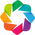

BokehModel(combine_events=True, render_bundle={'docs_json': {'d9bcd3af-5c4b-46db-847f-ddfb4b3fc8a0': {'version…

In [8]:
import panel as pn
import numpy as np
import holoviews as hv
from holoviews import streams
import pandas as pd

hv.extension('bokeh')
pn.extension()

# ── 1. Reshape intensity to (x, y, wavelength) for image display ──────────────
ds_indexed = ds_img.set_index(sample=["x", "y"])
intensity_unstacked = ds_indexed["intensity"].unstack("sample")  # (wavelength, x, y)

# Build a lookup: (x, y) → sample index
xy_to_sample = {
    (int(ds_img["x"].values[i]), int(ds_img["y"].values[i])): int(ds_img["sample"].values[i])
    for i in range(len(ds_img["sample"]))
}

x_vals = np.arange(256)
y_vals = np.arange(256)
wl_vals = ds_img["wavelength"].values

# ── 2. Wavelength slider ───────────────────────────────────────────────────────
wl_slider = pn.widgets.DiscreteSlider(
    name="Wavelength (nm)",
    options={f"{w:.0f} nm": i for i, w in enumerate(wl_vals)},
    value=0,
)

# ── 3. Selection stream (BoundsXY for box select) ─────────────────────────────
bounds_stream = streams.BoundsXY(bounds=(0, 0, 0, 0))
selected_samples = pn.pane.Markdown("**Selected samples:** none")

# ── 4. Image DynamicMap ────────────────────────────────────────────────────────
def make_image(wl_idx):
    data = intensity_unstacked.isel(wavelength=wl_idx).values  # shape (x, y)
    img = hv.Image(
        (x_vals, y_vals, data.T),  # hv.Image expects (x, y, z) with z as (y,x)
        kdims=["x", "y"],
        vdims=["intensity"],
    ).opts(
        tools=["box_select", "lasso_select"],
        colorbar=True,
        cmap="viridis",
        width=400,
        height=400,
        title=f"Wavelength: {wl_vals[wl_idx]:.0f} nm",
    )
    return img

image_dmap = hv.DynamicMap(
    pn.bind(make_image, wl_idx=wl_slider),
)

# Link BoundsXY stream to the image
bounds_stream.source = image_dmap

# ── 5. Callback: convert box bounds → sample indices ──────────────────────────
@pn.depends(bounds_stream.param.bounds, watch=True)
def update_selection(bounds):
    if bounds is None or bounds == (0, 0, 0, 0):
        selected_samples.object = "**Selected samples:** none"
        return
    x0, y0, x1, y1 = bounds
    x_sel = np.where((x_vals >= min(x0, x1)) & (x_vals <= max(x0, x1)))[0]
    y_sel = np.where((y_vals >= min(y0, y1)) & (y_vals <= max(y0, y1)))[0]

    # Get sample indices for selected (x, y) pairs
    selected_idx = [
        xy_to_sample[(int(x), int(y))]
        for x in x_vals[x_sel]
        for y in y_vals[y_sel]
        if (int(x), int(y)) in xy_to_sample
    ]
    selected_samples.object = (
        f"**Selected samples:** {len(selected_idx)}  \n"
        f"Sample indices (first 10): `{selected_idx[:10]}`"
    )

# ── 6. Layout ──────────────────────────────────────────────────────────────────
dashboard = pn.Column(
    wl_slider,
    pn.Row(image_dmap),
    selected_samples,
)
dashboard.servable()
dashboard

In [9]:

# ── Pre-extract arrays from ds_img for fast indexing ──────────────────────────
x_arr   = ds_img["x"].values.astype(int)
y_arr   = ds_img["y"].values.astype(int)
G_arr   = ds_img["G"].values
S_arr   = ds_img["S"].values
wl_vals2 = ds_img["wavelength"].values
G_ref   = ds_img["G_ref"].values
S_ref   = ds_img["S_ref"].values
wl_ref  = ds_img["wavelength_ref"].values

# ds_img already has intensity_unstacked from the cell above; reuse it
x_dim   = np.arange(256)
y_dim   = np.arange(256)

# ── Wavelength slider (new) ────────────────────────────────────────────────────
wl_slider2 = pn.widgets.DiscreteSlider(
    name="Wavelength (nm)",
    options={f"{w:.0f} nm": i for i, w in enumerate(wl_vals2)},
    value=0,
)

# ── Image DynamicMap ───────────────────────────────────────────────────────────
def make_image2(wl_idx):
    data = intensity_unstacked.isel(wavelength=wl_idx).values  # (x, y) already
    return hv.Image(
        (x_dim, y_dim, data.T),          # hv.Image expects z as (y, x)
        kdims=["x", "y"],
        vdims=["intensity"],
    ).opts(
        tools=["box_select"],
        active_tools=["box_select"],
        colorbar=True,
        cmap="viridis",
        frame_width=350,
        frame_height=350,
        title=f"Wavelength: {wl_vals2[wl_idx]:.0f} nm",
    )

image_dmap2 = hv.DynamicMap(pn.bind(make_image2, wl_idx=wl_slider2))

# ── BoundsXY stream wired to the image ────────────────────────────────────────
sel_bounds = streams.BoundsXY(source=image_dmap2, bounds=(0, 0, 255, 255))

# ── Reference semicircle (static) ─────────────────────────────────────────────
ref_pts = hv.Points(
    pd.DataFrame({"G": G_ref, "S": S_ref, "wl": wl_ref}),
    kdims=["G", "S"],
    vdims=["wl"],
).opts(
    color="wl",
    cmap="Spectral_r",
    size=6,
    alpha=0.6,
    colorbar=False,
    tools=["hover"],
)

# ── Helper: boolean mask from box bounds ──────────────────────────────────────
def _mask(bounds):
    x0, y0, x1, y1 = bounds
    return (
        (x_arr >= min(x0, x1)) & (x_arr <= max(x0, x1)) &
        (y_arr >= min(y0, y1)) & (y_arr <= max(y0, y1))
    )

# ── Phasor DynamicMap ──────────────────────────────────────────────────────────
def make_phasor(bounds):
    mask = _mask(bounds)
    n_sel = int(mask.sum())

    all_pts = hv.Points(
        pd.DataFrame({"G": G_arr, "S": S_arr}), kdims=["G", "S"]
    ).opts(color="lightgray", size=3, alpha=0.25)

    if n_sel:
        sel_pts = hv.Points(
            pd.DataFrame({"G": G_arr[mask], "S": S_arr[mask]}), kdims=["G", "S"]
        ).opts(color="steelblue", size=5, alpha=0.85)
    else:
        sel_pts = hv.Points(pd.DataFrame({"G": [], "S": []}), kdims=["G", "S"])

    return (ref_pts * all_pts * sel_pts).opts(
        hv.opts.Points(
            frame_width=350,
            frame_height=350,
            xlabel="G",
            ylabel="S",
            show_grid=True,
            padding=0.1,
            title=f"Phasor Plot  ({n_sel} px selected)",
        )
    )

phasor_map = hv.DynamicMap(make_phasor, streams=[sel_bounds])

# ── Spectrum DynamicMap ────────────────────────────────────────────────────────
def make_spectrum(bounds):
    mask = _mask(bounds)
    n_sel = int(mask.sum())

    if n_sel == 0:
        avg = np.zeros_like(wl_vals2)
        title = "Average Spectrum (no selection)"
        color = "gray"
    else:
        avg = ds_img["intensity"].values[mask].mean(axis=0)
        title = f"Average Spectrum  ({n_sel} px)"
        color = "steelblue"

    return hv.Curve(
        pd.DataFrame({"wavelength": wl_vals2, "intensity": avg}),
        kdims=["wavelength"],
        vdims=["intensity"],
    ).opts(
        frame_width=550,
        frame_height=350,
        title=title,
        xlabel="Wavelength (nm)",
        ylabel="Intensity",
        line_width=2,
        color=color,
        show_grid=True,
        tools=["hover"],
    )

spectrum_map = hv.DynamicMap(make_spectrum, streams=[sel_bounds])

# ── Layout ─────────────────────────────────────────────────────────────────────
dashboard2 = pn.Column(
    pn.pane.Markdown("## Image × Phasor × Spectrum prototype"),
    wl_slider2,
    pn.Row(image_dmap2, phasor_map, spectrum_map),
)
dashboard2.servable()
dashboard2


BokehModel(combine_events=True, render_bundle={'docs_json': {'7aef9719-6e31-41b4-958f-e545a4a9f2b6': {'version…

In [13]:

# ══════════════════════════════════════════════════════════════════════════════
# Bidirectional prototype v3 — box + lasso, wheel zoom, exclusive selection
# ══════════════════════════════════════════════════════════════════════════════
from matplotlib.path import Path as MplPath

# ── Pre-extract arrays ─────────────────────────────────────────────────────────
_x      = ds_img["x"].values.astype(int)
_y      = ds_img["y"].values.astype(int)
_G      = ds_img["G"].values
_S      = ds_img["S"].values
_wl     = ds_img["wavelength"].values
_Gref   = ds_img["G_ref"].values
_Sref   = ds_img["S_ref"].values
_wlref  = ds_img["wavelength_ref"].values
_intmat = ds_img["intensity"].values          # (n_samples, n_wl)
_xdim   = np.arange(256)
_ydim   = np.arange(256)
_EMPTY  = (0.0, 0.0, 0.0, 0.0)
_IMG_WW = 370   # image frame width — slider will match this

# ── Mask helpers ───────────────────────────────────────────────────────────────
def _imask_box(b):
    if b is None or b == _EMPTY:
        return np.zeros(len(_x), dtype=bool)
    x0, y0, x1, y1 = b
    return ((_x >= min(x0,x1)) & (_x <= max(x0,x1)) &
            (_y >= min(y0,y1)) & (_y <= max(y0,y1)))

def _pmask_box(b):
    if b is None or b == _EMPTY:
        return np.zeros(len(_G), dtype=bool)
    g0, s0, g1, s1 = b
    return ((_G >= min(g0,g1)) & (_G <= max(g0,g1)) &
            (_S >= min(s0,s1)) & (_S <= max(s0,s1)))

def _imask_lasso(geom):
    if geom is None or len(geom) < 3:
        return np.zeros(len(_x), dtype=bool)
    return MplPath(geom).contains_points(np.column_stack([_x.astype(float), _y.astype(float)]))

def _pmask_lasso(geom):
    if geom is None or len(geom) < 3:
        return np.zeros(len(_G), dtype=bool)
    return MplPath(geom).contains_points(np.column_stack([_G, _S]))

def _imask(bounds, geom):
    return _imask_box(bounds) | _imask_lasso(geom)

def _pmask(bounds, geom):
    return _pmask_box(bounds) | _pmask_lasso(geom)

# ── Controls ───────────────────────────────────────────────────────────────────
wl_slider_v2 = pn.widgets.DiscreteSlider(
    name="Wavelength (nm)",
    options={f"{w:.0f} nm": i for i, w in enumerate(_wl)},
    value=0,
    width=_IMG_WW,
)
mode_toggle = pn.widgets.RadioButtonGroup(
    name="Selection mode",
    options=["Image", "Phasor"],
    value="Image",
    button_type="primary",
)
reset_btn = pn.widgets.Button(name="↺  Reset", button_type="warning", width=100)

# ── Streams ────────────────────────────────────────────────────────────────────
img_bounds_v2 = streams.BoundsXY(bounds=_EMPTY)
ph_bounds_v2  = streams.BoundsXY(bounds=_EMPTY)
img_lasso_v2  = streams.Lasso(geometry=None)
ph_lasso_v2   = streams.Lasso(geometry=None)

def _reset_all():
    img_bounds_v2.event(bounds=_EMPTY)
    ph_bounds_v2.event(bounds=_EMPTY)
    img_lasso_v2.event(geometry=None)
    ph_lasso_v2.event(geometry=None)

mode_toggle.param.watch(lambda e: _reset_all(), "value")
reset_btn.on_click(lambda e: _reset_all())

# ── Base image DynamicMap ──────────────────────────────────────────────────────
def _base_image_v2(wl_idx):
    data = intensity_unstacked.isel(wavelength=wl_idx).values
    return hv.Image(
        (_xdim, _ydim, data.T),
        kdims=["x", "y"], vdims=["intensity"],
    ).opts(
        cmap="viridis", colorbar=True,
        frame_width=_IMG_WW, frame_height=_IMG_WW,
        title=f"Image  —  {_wl[wl_idx]:.0f} nm",
        tools=["box_select", "lasso_select", "wheel_zoom"],
        active_tools=["wheel_zoom"],
    )

base_img_dmap_v2 = hv.DynamicMap(pn.bind(_base_image_v2, wl_idx=wl_slider_v2))
img_bounds_v2.source = base_img_dmap_v2
img_lasso_v2.source  = base_img_dmap_v2

# ── Static gray phasor background ─────────────────────────────────────────────
_df_all_v2 = pd.DataFrame({"G": _G, "S": _S})
phasor_bg_v2 = hv.Points(_df_all_v2, kdims=["G", "S"]).opts(
    color="lightgray", size=3, alpha=0.3,
    frame_width=_IMG_WW, frame_height=_IMG_WW,
    tools=["box_select", "lasso_select", "wheel_zoom"],
    active_tools=["wheel_zoom"],
    xlabel="G", ylabel="S", show_grid=True, padding=0.1,
    title="Phasor",
)
ph_bounds_v2.source = phasor_bg_v2
ph_lasso_v2.source  = phasor_bg_v2

# ── Static reference arc ───────────────────────────────────────────────────────
ref_arc_v2 = hv.Points(
    pd.DataFrame({"G": _Gref, "S": _Sref, "wl": _wlref}),
    kdims=["G", "S"], vdims=["wl"],
).opts(color="wl", cmap="Spectral_r", size=6, alpha=0.6, colorbar=False, tools=["hover"])

# ── Callbacks (pn.bind watches streams + toggle simultaneously) ────────────────
def _make_phasor_overlay(ibounds, igeom, pbounds, pgeom, mode):
    if mode == "Image":
        m, color = _imask(ibounds, igeom), "steelblue"
    else:
        m, color = _pmask(pbounds, pgeom), "tomato"
    df = pd.DataFrame({"G": _G[m], "S": _S[m]}) if m.any() else pd.DataFrame({"G": [], "S": []})
    return hv.Points(df, kdims=["G", "S"]).opts(color=color, size=5, alpha=0.9)

def _make_image_overlay(pbounds, pgeom, mode):
    if mode != "Phasor":
        return hv.Points(pd.DataFrame({"x": [], "y": []}), kdims=["x", "y"])
    m = _pmask(pbounds, pgeom)
    df = pd.DataFrame({"x": _x[m].astype(float), "y": _y[m].astype(float)}) if m.any() \
         else pd.DataFrame({"x": [], "y": []})
    return hv.Points(df, kdims=["x", "y"]).opts(color="tomato", size=2, alpha=0.7)

def _make_spectrum(ibounds, igeom, pbounds, pgeom, mode):
    if mode == "Image":
        mask, color, src = _imask(ibounds, igeom), "steelblue", "image sel"
    else:
        mask, color, src = _pmask(pbounds, pgeom), "tomato", "phasor sel"
    n = int(mask.sum())
    if n == 0:
        avg, title, color = np.zeros_like(_wl), "Average Spectrum (no selection)", "gray"
    else:
        avg   = _intmat[mask].mean(axis=0)
        title = f"Average Spectrum — {src}  ({n} px)"
    return hv.Curve(
        pd.DataFrame({"wavelength": _wl, "intensity": avg}),
        kdims=["wavelength"], vdims=["intensity"],
    ).opts(
        frame_width=560, frame_height=_IMG_WW,
        title=title, color=color,
        xlabel="Wavelength (nm)", ylabel="Intensity",
        line_width=2, show_grid=True, tools=["hover"],
    )

# ── Wire DynamicMaps ───────────────────────────────────────────────────────────
img_overlay_dmap = hv.DynamicMap(pn.bind(
    _make_image_overlay,
    pbounds=ph_bounds_v2.param.bounds,
    pgeom=ph_lasso_v2.param.geometry,
    mode=mode_toggle,
))
ph_overlay_dmap = hv.DynamicMap(pn.bind(
    _make_phasor_overlay,
    ibounds=img_bounds_v2.param.bounds,
    igeom=img_lasso_v2.param.geometry,
    pbounds=ph_bounds_v2.param.bounds,
    pgeom=ph_lasso_v2.param.geometry,
    mode=mode_toggle,
))
spectrum_v2 = hv.DynamicMap(pn.bind(
    _make_spectrum,
    ibounds=img_bounds_v2.param.bounds,
    igeom=img_lasso_v2.param.geometry,
    pbounds=ph_bounds_v2.param.bounds,
    pgeom=ph_lasso_v2.param.geometry,
    mode=mode_toggle,
))

# ── Composed panels ────────────────────────────────────────────────────────────
image_panel_v2 = (base_img_dmap_v2 * img_overlay_dmap).opts(
    hv.opts.Overlay(title="Image"),
)
phasor_panel_v2 = (ref_arc_v2 * phasor_bg_v2 * ph_overlay_dmap).opts(
    hv.opts.Overlay(
        frame_width=_IMG_WW, frame_height=_IMG_WW,
        xlabel="G", ylabel="S",
        show_grid=True, padding=0.1,
        title="Phasor",
    ),
)

# ── Layout ─────────────────────────────────────────────────────────────────────
dashboard_v2 = pn.Column(
    pn.Row(mode_toggle, reset_btn, align="center"),
    pn.Row(
        pn.Column(image_panel_v2, wl_slider_v2),
        phasor_panel_v2,
        spectrum_v2,
    ),
)
dashboard_v2.servable()
dashboard_v2


BokehModel(combine_events=True, render_bundle={'docs_json': {'1e1db72d-78f6-44bc-9717-3ccdefda4c9c': {'version…